# Slope primary dependence

Parameterize the primary dependence of mean square slope on wind speed in Hurricane Idalia (2023).

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

from configure import read_stored_variable
from src import stats, plotting

# Setup

Run the previous notebook and read stored variables.

In [43]:
%%capture
%run 'nb4-spectra.ipynb'
%run -i configure.py

In [44]:
microswift_df = read_stored_variable('microswift_df')
spotter_df = read_stored_variable('spotter_df')
ian_spotter_coamps_df = read_stored_variable('ian_spotter_coamps_df')
fiona_spotter_coamps_df = read_stored_variable('fiona_spotter_coamps_df')

plotting.configure_figures()

## Fitting

Combine mean square slope and wind speed data from each buoy in to a single DataFrame, `fit_df`.

In [45]:
spotter_fit_data = (spotter_df[['wind_speed', 'mean_square_slope_intrinsic']]
                    .dropna()
                    .sort_values(by='wind_speed', axis=0))

microswift_fit_data = (microswift_df[['wind_speed', 'mean_square_slope_intrinsic']]
                       .dropna()
                       .sort_values(by='wind_speed', axis=0))

fit_df = pd.concat((spotter_fit_data, microswift_fit_data))
fit_df.sort_values(by='wind_speed', axis=0, inplace=True)

Fit a $a\tanh(b U_{10}) + U_{10} c + d$ function to the mean square slope versus wind speed data.  The linear term, $c U_{10}$, is an augmentation to the originally proposed tanh fit to the Ian and Fiona data, which were not adjusted for the surface drift Doppler shift (Davis et al., 2023).  This term is necessary to capture the trend at high winds where the spectrum is dominated by the saturation range (such that the increase in slope with wind speed is drastically reduced, but is nonzero).

In [46]:
def mss_tanh_fit(u, a, b, c, d):
     return a*np.tanh(b*u) + c*u + d

Fit the function using nonlinear least squares.  Here `popt` are the optimal parameters ($a$, $b$, $c$, and $d$) and `pcov` is the estimated approximate covariance of the parameters.

In [47]:
tanh_fit = {
     'fun': mss_tanh_fit,
}

# fit the model
tanh_fit['popt'], tanh_fit['pcov'] = curve_fit(
   tanh_fit['fun'],
   xdata=fit_df['wind_speed'],
   ydata=fit_df['mean_square_slope_intrinsic'],
)

# Approximate parameter confidence intervals using the covariance matrix.
tanh_fit['perr'], tanh_fit['t_value'], tanh_fit['popt_upper'], tanh_fit['popt_lower'] \
   = stats.parameter_confidence_intervals(
    popt=tanh_fit['popt'],
    pcov=tanh_fit['pcov'],
    n=len(fit_df['mean_square_slope_intrinsic']),
    alpha=0.05,  # 95% confidence interval
)

# Calculate the RMSE.
fit_df['tanh_fit'] = tanh_fit['fun'](fit_df['wind_speed'], *tanh_fit['popt'])
tanh_fit['rmse'] = stats.root_mean_square_error(
   y=fit_df['mean_square_slope_intrinsic'],
   y_hat=fit_df['tanh_fit']
)

# Calculate residuals.
fit_df['tanh_fit_residuals'] = fit_df['mean_square_slope_intrinsic'] - fit_df['tanh_fit']

Print the coefficients.

In [48]:
# Parameters +/- 95% confidence intervals.
stats.print_fit_parameters(tanh_fit, parameter_names=['a', 'b', 'c', 'd'], print_format='0.6f')

# Root mean square error.
print(f'RMSE: {tanh_fit["rmse"]:.5f}')

# Upper and lower wind speeds.
print(f'Valid U_{10} range: {fit_df['wind_speed'].min():0.0f} m/s '
      f'to {fit_df['wind_speed'].max():0.0f} m/s')


a: 0.017394 +/- 0.003598
b: 0.057513 +/- 0.011156
c: 0.000088 +/- 0.000098
d: -0.001407 +/- 0.000617
RMSE: 0.00165
Valid U_10 range: 2 m/s to 52 m/s


Here, uncertainties represent 95\% confidence intervals on the parameters derived from the covariance matrix estimated during the nonlinear least squares fitting.  These coefficients are valid for $U_{10} \in [2, 52]$ m/s and for an mss integrated over frequencies from 0.05 Hz to 0.5 Hz (624 m to 6.2 m wavelength).

Plot the fit on top of the original data and plot the residuals.

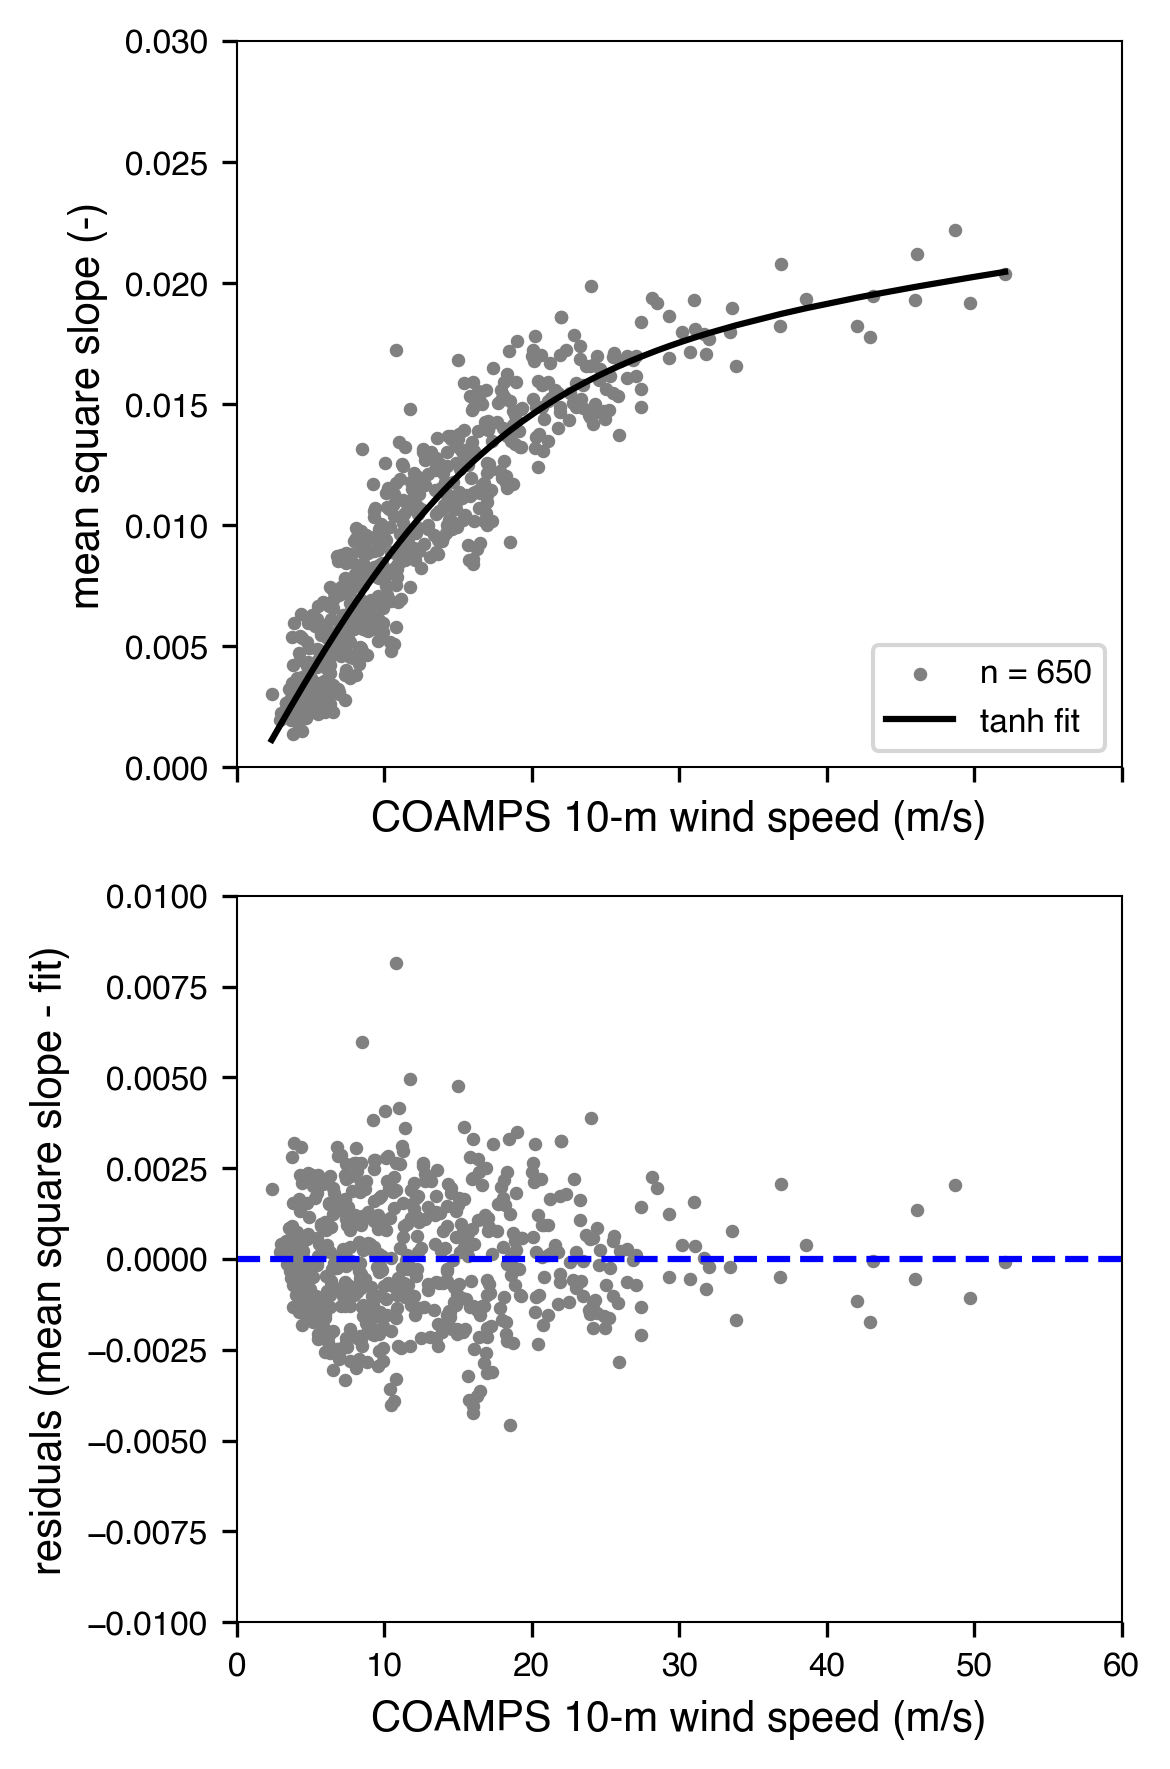

In [49]:
fig, ax = plt.subplots(2, 1, figsize=(4, 6), sharex=True)

# fit plot
ax[0].scatter(
    fit_df['wind_speed'],
    fit_df['mean_square_slope_intrinsic'],
    s=5,
    color='grey',
    label=f'n = {fit_df["mean_square_slope_intrinsic"].size}'
)
ax[0].plot(
    fit_df['wind_speed'],
    fit_df['tanh_fit'],
    color='k',
    label='tanh fit'
)
ax[0].set_xlabel('COAMPS 10-m wind speed (m/s)')
ax[0].set_ylabel('mean square slope (-)')
ax[0].legend(frameon=True, loc='lower right')
ax[0].set_ylim([0, 0.03])

# residual plot
ax[1].scatter(
    fit_df['wind_speed'],
    fit_df['tanh_fit_residuals'],
    s=5,
    color='grey',
)
ax[1].set_xlabel('COAMPS 10-m wind speed (m/s)')
ax[1].set_ylabel('residuals (mean square slope - fit)')
ax[1].axhline(0, color='b', linestyle='--')
ax[1].set_ylim(0.01 * np.array([-1, 1]))
ax[1].set_xlim([0, 60])

fig.tight_layout()
# fig.savefig('idalia_mss_fit_and_residuals_spotter_only.png', dpi=400)

Calculate the residuals (observations minus fit) for each buoy observation and add it to the DataFrame.

In [50]:
spotter_df['mean_square_slope_intrinsic_residual'] = stats.calculate_residuals(
    spotter_df['mean_square_slope_intrinsic'],
    spotter_df['wind_speed'],
    tanh_fit['fun'],
     *tanh_fit['popt'],
)

microswift_df['mean_square_slope_intrinsic_residual'] = stats.calculate_residuals(
    microswift_df['mean_square_slope_intrinsic'],
    microswift_df['wind_speed'],
    tanh_fit['fun'],
    *tanh_fit['popt'],
)

## Store

In [51]:
%%capture
%store microswift_df
%store spotter_df
%store fit_df
%store tanh_fit

## References

Davis, J. R., Thomson, J., Houghton, I. A., Doyle, J. D., Komaromi, W. A., Fairall, C. W., Thompson, E. J., & Moskaitis, J. R. (2023). Saturation of Ocean Surface Wave Slopes Observed During Hurricanes. Geophysical Research Letters, 50(16), e2023GL104139. https://doi.org/10.1029/2023GL104139
